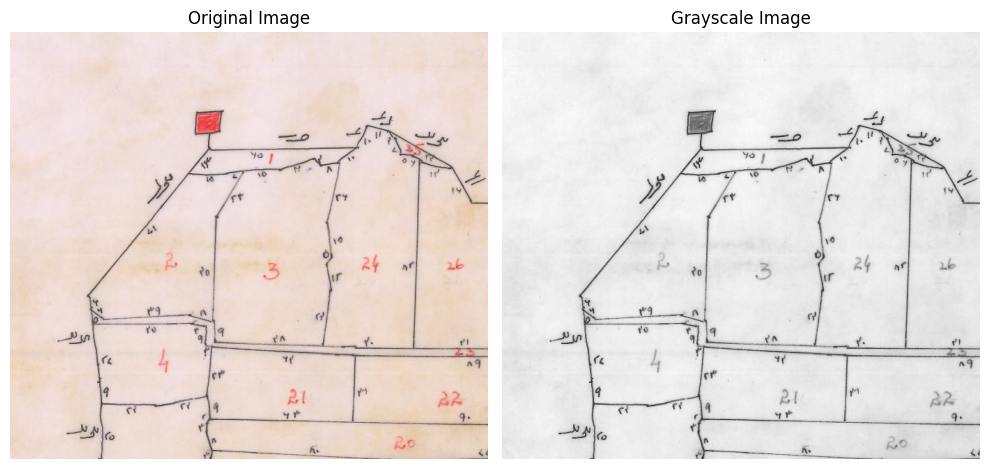

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('./map_cropped.png', cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.tight_layout()
plt.show()

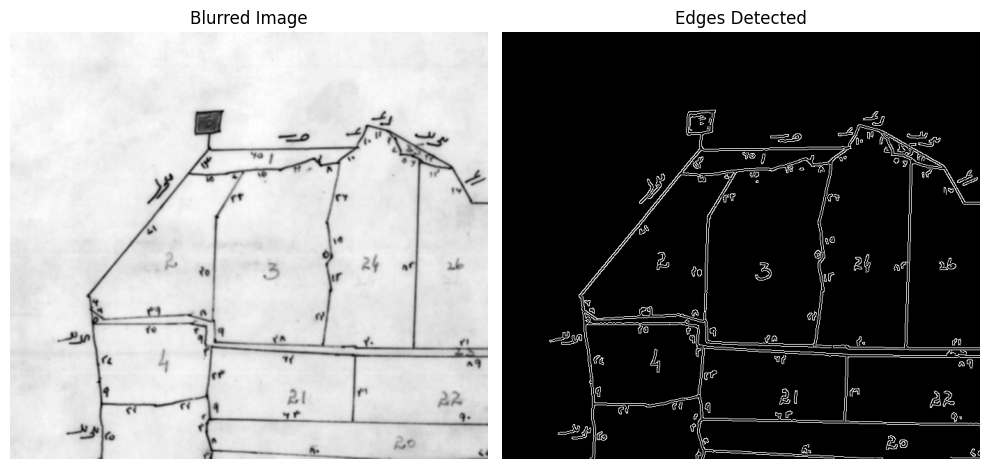

In [19]:
# Apply Gaussian blur to the grayscale image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges using Canny
edges = cv2.Canny(blurred, 50, 100)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')

plt.tight_layout()
plt.show()

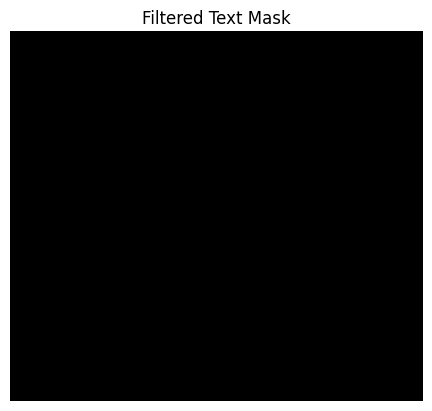

In [53]:
# Find contours in the binary thresholded image
text_mask = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

contours, _ = cv2.findContours(text_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to compute solidity of a contour
def solidity(contour):
    area = cv2.contourArea(contour)
    hull_area = cv2.contourArea(cv2.convexHull(contour))
    if hull_area == 0:
        return 0
    return float(area) / hull_area

# Blank mask to draw filtered text contours
filtered_text_mask = np.zeros_like(text_mask)

# Iterate over contours and filter based on aspect ratio and solidity
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    cont_solidity = solidity(contour)
    
    # Check if contour properties match typical text regions
    if 0 < aspect_ratio < 0.1 and cont_solidity > 0:
        cv2.drawContours(filtered_text_mask, [contour], -1, 255, -1)

plt.imshow(filtered_text_mask, cmap='gray')
plt.title('Filtered Text Mask')
plt.axis('off')
plt.show()

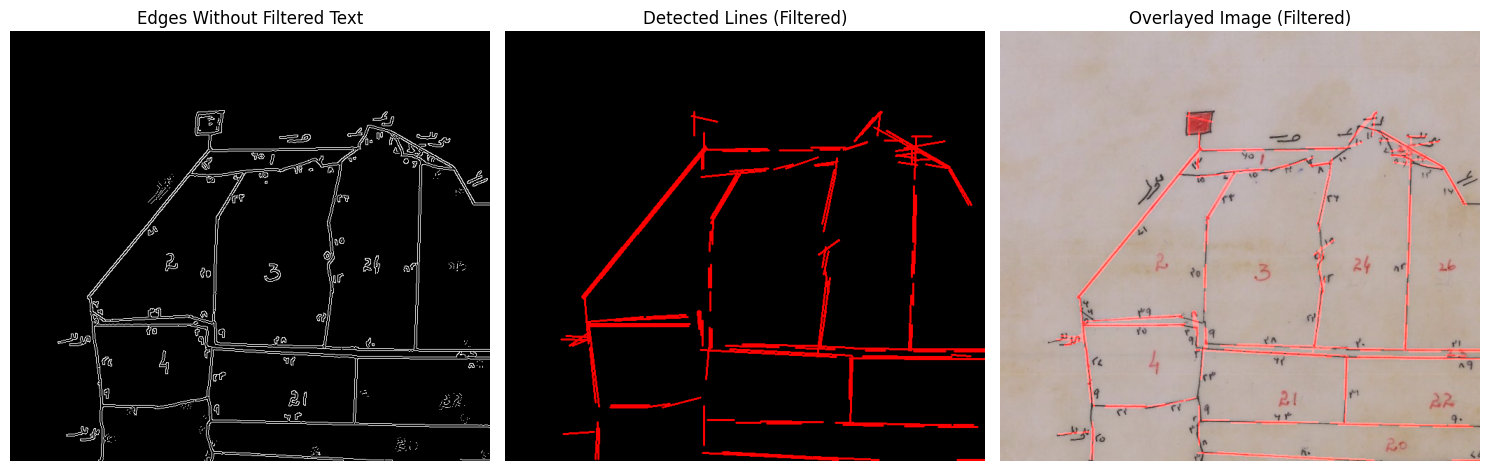

In [51]:
# Subtract the filtered text mask from the edge-detected image
edges_without_filtered_text = cv2.subtract(edges, filtered_text_mask)

# Use Hough Line Transform to detect lines again
lines_filtered = cv2.HoughLinesP(edges_without_filtered_text, 1, np.pi/180, threshold=40, minLineLength=25, maxLineGap=7)

# Create a blank image to draw the detected lines on
line_image_filtered = np.zeros_like(image_rgb)

# Draw the detected lines on the blank image
if lines_filtered is not None:
    for line in lines_filtered:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image_filtered, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Overlay the line image onto the original image
combined_image_filtered = cv2.addWeighted(image_rgb, 0.8, line_image_filtered, 1, 0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(edges_without_filtered_text, cmap='gray')
plt.title('Edges Without Filtered Text')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(line_image_filtered)
plt.title('Detected Lines (Filtered)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(combined_image_filtered)
plt.title('Overlayed Image (Filtered)')
plt.axis('off')

plt.tight_layout()
plt.show()